### Installing MediaPipe

In [ ]:
%%capture
!pip install mediapipe

### Required Libraries

In [ ]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

### Adding Data to Colab

In [ ]:
# link of the data
# http://www.cbsr.ia.ac.cn/users/xiangyuzhu/projects/3DDFA/Database/AFLW2000-3D.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/AFLW2000-3D.zip

### Exploring Data

In [ ]:
image = cv2.imread('/content/AFLW2000/image00053.jpg')
image

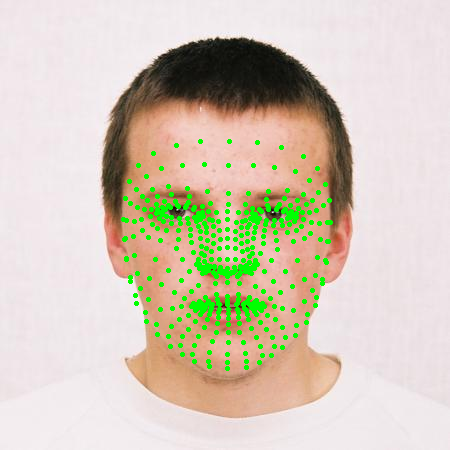

In [ ]:
# choosing random image
random_file = 'image00056'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              #cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

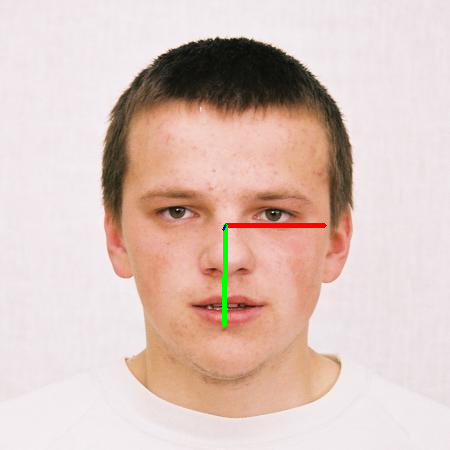

In [ ]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angles of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angles
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))

## Go through all files if it's a jpg file get the features if it's a mat file get the labels

In [ ]:
#Files is a list of paths to each file in the dataset folder
directory = 'AFLW2000'
files = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        files.append(f)

In [ ]:
#to get jpg and mat files for the same picture in order
sorted_files = sorted(files)

In [ ]:
# Function that takes in the path of the image file 
# and returns all the X and Y coordinates of the landmarks
def get_features(jpg_file):
  features_X = []
  features_Y = []
  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      image = cv2.imread(jpg_file)
      # processing the face to extract the landmark points (468 point) for each x,y
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                features_X.append(x)
                y = landmark.y
                features_Y.append(y)
            # Not scaling the features relative to image shape so that they are scale invariant and won't need normalization 
  return np.array(features_X), np.array(features_Y)

In [ ]:
# Function that takes in the path of the mat file 
# and returns the pitch yaw and roll angles of the face in it (labels)
def get_labels(mat_file):
  mat = sio.loadmat(mat_file)
  pose_para = mat["Pose_Para"][0][:3]
  pitch = pose_para[0]
  yaw = pose_para[1]
  roll = pose_para[2]
  output = np.array([pitch, yaw, roll])
  return output

In [ ]:
# Looping through the file paths and compiling all x and y coordinates into feature lists
# and also adding labels into labels list
features_x = np.empty((0, 468), float)
features_y = np.empty((0, 468), float)
labels = np.empty((0,3), float)
for path in sorted_files:
  if path.endswith('.jpg'):
    sample_x, sample_y = get_features(path)
    if sample_x.any():
      sample_x = sample_x.reshape(1,468)
      features_x = np.append(features_x, sample_x, axis = 0)
      sample_y = sample_y.reshape(1,468)
      features_y = np.append(features_y, sample_y, axis = 0)
  else:
    if sample_x.any():
      label = get_labels(path)
      label = label.reshape(1,3)
      labels = np.append(labels, label, axis = 0)

# Dividing labels into pitch, yaw and roll labels
label_pitch = labels[:,0]
label_yaw = labels[:,1]
label_roll = labels[:,2]

## Data Preparation

Tried training the model on relevant points only. 
Model was performing at a slightly less accuracy but with faster execution time, so it could be a good idea if high execution speed is needed in the application.

Found the indices of landmark points that represent a cross on the face (vertical line in the middle of the face and horizontal line through the eyes) and the four corners of the face (jaws and ears) from the mediapipe library.

In [ ]:
vert_line = [10, 151, 9, 8, 168, 6, 197, 195, 5, 4, 1, 19, 24, 2, 164, 0, 11, 12, 13, 14, 15, 16, 17, 18, 200, 199, 175, 152]
horz_line = [127, 34, 143, 35, 226, 130, 33, 190, 180, 193, 417, 413, 414, 398, 263, 359, 446, 265, 372, 264, 356]
corners = [21, 251, 58, 288]
relevant_pts = vert_line + horz_line + corners

Transforming the features into relative distances with the nose tip landmark as the new origin

In [ ]:
features_x_relative = features_x - features_x[:,1].reshape(1853,1)
features_y_relative = features_y - features_y[:,1].reshape(1853,1)
features_final_full = np.append(features_x_relative, features_y_relative, axis = 1)

In [ ]:
features_x_select = features_x_relative[:, relevant_pts]
features_y_select = features_y_relative[:, relevant_pts]
features_final_select = np.append(features_x_select, features_y_select, axis = 1)

In [ ]:
print(features_final_select.shape)
print(features_final_full.shape)

(1853, 106)
(1853, 936)


## Roll Model

Split the data to train and test data and try out multiple regression models then perform gridsearch on the best model

In [ ]:
features_train, features_test, labels_train_roll, labels_test_roll = train_test_split(features_final_full, label_roll, test_size=0.3, random_state = 33)

In [ ]:
#features_validation, features_test, labels_validation, labels_test = train_test_split(features_validation_test, labels_validation_test, test_size=0.5,random_state = 1)

In [ ]:
svr = SVR().fit(features_train, labels_train_roll)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(svr.score(features_test, labels_test_roll))

0.042420019554158535
0.6974631537105731


In [ ]:
svr = SVR(kernel = 'poly').fit(features_train, labels_train_roll)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(svr.score(features_test, labels_test_roll))

0.055904311542046725
0.6012940520614544


In [ ]:
svr = SVR(kernel = 'linear').fit(features_train, labels_train_roll)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(svr.score(features_test, labels_test_roll))

0.04689817936347066
0.6655252064835655


In [ ]:
svr = SVR(kernel = 'sigmoid').fit(features_train, labels_train_roll)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(svr.score(features_test, labels_test_roll))

42.672433898730006
-303.33704913156294


In [ ]:
reg = LinearRegression().fit(features_train, labels_train_roll)
predict = reg.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(reg.score(features_test, labels_test_roll))

0.3997694412171212
-1.8511298971538954


In [ ]:
ridge = Ridge().fit(features_train, labels_train_roll)
predict = ridge.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(ridge.score(features_test, labels_test_roll))

0.07261123986830534
0.4821413156852574


In [ ]:
lasso = Lasso().fit(features_train, labels_train_roll)
predict = lasso.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(lasso.score(features_test, labels_test_roll))

0.14073500337565784
-0.003712976356452069


In [ ]:
gbr = GradientBoostingRegressor().fit(features_train, labels_train_roll)
predict = gbr.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(gbr.score(features_test, labels_test_roll))

0.094532409855571
0.3258009437423679


In [ ]:
abr = AdaBoostRegressor().fit(features_train, labels_train_roll)
predict = abr.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(abr.score(features_test, labels_test_roll))

0.09125233427479826
0.34919423144538275


In [ ]:
svr_parameters = {'kernel': ['rbf'],
                  'C': [0.01, 0.1, 1 , 10],
                  'gamma': [0.01, 0.1, 1, 10]
                }
# use gridsearch to find the best hyperparameters
svr = SVR()
svr_gs = GridSearchCV(svr, svr_parameters).fit(features_train, labels_train_roll)

# get the best model
svr_winner_roll = svr_gs.best_estimator_

predict = svr_winner_roll.predict(features_test)
print(mean_squared_error(labels_test_roll, predict))
print(svr_winner_roll.score(features_test, labels_test_roll))
print(svr_winner_roll)

0.046508004424306616
0.6683079090102616
SVR(C=10, gamma=0.1)


## Yaw Model

In [ ]:
features_train, features_test, labels_train_yaw, labels_test_yaw = train_test_split(features_final_full, label_yaw, test_size=0.3, random_state = 22)

In [ ]:
svr = SVR().fit(features_train, labels_train_yaw)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(svr.score(features_test, labels_test_yaw))

0.01908459204381835
0.9381530522599583


In [ ]:
svr = SVR(kernel = 'poly').fit(features_train, labels_train_yaw)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(svr.score(features_test, labels_test_yaw))

0.16132837427501087
0.4771872770524145


In [ ]:
svr = SVR(kernel = 'linear').fit(features_train, labels_train_yaw)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(svr.score(features_test, labels_test_yaw))

0.023013072756727652
0.9254221256155104


In [ ]:
svr = SVR(kernel = 'sigmoid').fit(features_train, labels_train_yaw)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(svr.score(features_test, labels_test_yaw))

55.80547296055437
-179.84736429656382


In [ ]:
reg = LinearRegression().fit(features_train, labels_train_yaw)
predict = reg.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(reg.score(features_test, labels_test_yaw))

0.11287367677293367
0.6342131719360926


In [ ]:
ridge = Ridge().fit(features_train, labels_train_yaw)
predict = ridge.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(ridge.score(features_test, labels_test_yaw))

0.025651054020592312
0.9168732874223308


In [ ]:
lasso = Lasso().fit(features_train, labels_train_yaw)
predict = lasso.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(lasso.score(features_test, labels_test_yaw))

0.30869543182741194
-0.00038136502915619985


In [ ]:
gbr = GradientBoostingRegressor().fit(features_train, labels_train_yaw)
predict = gbr.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(gbr.score(features_test, labels_test_yaw))

#Gradient boosting regressor shows a higher score than svr but showed worse results in the test pictures

0.01613730053179735
0.9477042642376685


In [ ]:
abr = AdaBoostRegressor().fit(features_train, labels_train_yaw)
predict = abr.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(abr.score(features_test, labels_test_yaw))

0.054418876859420914
0.8236461421093603


In [ ]:
svr_parameters = {'kernel': ['rbf'],
                  'C': [0.01, 0.1, 1 , 10, 100],
                  'gamma': [0.01, 0.1, 1, 10, 100]
                }
# use gridsearch to find the best hyperparameters
svr = SVR()
svr_gs = GridSearchCV(svr, svr_parameters).fit(features_train, labels_train_yaw)

# get the best model
svr_winner_yaw = svr_gs.best_estimator_

predict = svr_winner_yaw.predict(features_test)
print(mean_squared_error(labels_test_yaw, predict))
print(svr_winner_yaw.score(features_test, labels_test_yaw))
print(svr_winner_yaw)

0.01865238570366236
0.9395536922564103
SVR(C=10, gamma=0.1)


## Pitch Model

In [ ]:
features_train, features_test, labels_train_pitch, labels_test_pitch = train_test_split(features_final_full, label_pitch, test_size=0.3, random_state = 22)

In [ ]:
svr = SVR().fit(features_train, labels_train_pitch)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(svr.score(features_test, labels_test_pitch))

0.020567709870890405
0.734706640447518


In [ ]:
svr = SVR(kernel = 'poly').fit(features_train, labels_train_pitch)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(svr.score(features_test, labels_test_pitch))

0.029293166110594945
0.6221610233617993


In [ ]:
svr = SVR(kernel = 'linear').fit(features_train, labels_train_pitch)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(svr.score(features_test, labels_test_pitch))

0.026949325360147037
0.6523931391805071


In [ ]:
svr = SVR(kernel = 'sigmoid').fit(features_train, labels_train_pitch)
predict = svr.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(svr.score(features_test, labels_test_pitch))

56.50195454164727
-727.7925313867871


In [ ]:
reg = LinearRegression().fit(features_train, labels_train_pitch)
predict = reg.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(reg.score(features_test, labels_test_pitch))

0.22966901225455771
-1.9623941716693447


In [ ]:
ridge = Ridge().fit(features_train, labels_train_pitch)
predict = ridge.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(ridge.score(features_test, labels_test_pitch))

0.0278701695174556
0.6405155970695882


In [ ]:
lasso = Lasso().fit(features_train, labels_train_pitch)
predict = lasso.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(lasso.score(features_test, labels_test_pitch))

0.07769398692892042
-0.002138737797530599


In [ ]:
gbr = GradientBoostingRegressor().fit(features_train, labels_train_pitch)
predict = gbr.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(gbr.score(features_test, labels_test_pitch))

0.07328784935738969
0.05469398914870938


In [ ]:
abr = AdaBoostRegressor().fit(features_train, labels_train_pitch)
predict = abr.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(abr.score(features_test, labels_test_pitch))

0.04457177607408404
0.4250893128043336


In [ ]:
svr_parameters = {'kernel': ['rbf'],
                  'C': [0.01, 0.1, 1, 10, 100],
                  'gamma': [0.01, 0.1, 1, 10, 100]
                }
# use gridsearch to find the best hyperparameters
svr = SVR()
svr_gs = GridSearchCV(svr, svr_parameters).fit(features_train, labels_train_pitch)

# get the best model
svr_winner_pitch = svr_gs.best_estimator_

predict = svr_winner_pitch.predict(features_test)
print(mean_squared_error(labels_test_pitch, predict))
print(svr_winner_pitch.score(features_test, labels_test_pitch))
print(svr_winner_pitch)

0.018104247224911347
0.7664817036697384
SVR(C=10, gamma=0.1)


## Drawing the output on pictures to test

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [ ]:
def draw_picture(jpg):

  #get features from image
  features_x, features_y = get_features(jpg)

  #prepare features for prediction
  features_x_relative = features_x - features_x[1]
  features_y_relative = features_y - features_y[1]
  vert_line = [10, 151, 9, 8, 168, 6, 197, 195, 5, 4, 1, 19, 24, 2, 164, 0, 11, 12, 13, 14, 15, 16, 17, 18, 200, 199, 175, 152]
  horz_line = [127, 34, 143, 35, 226, 130, 33, 190, 180, 193, 417, 413, 414, 398, 263, 359, 446, 265, 372, 264, 356]
  corners = [21, 251, 58, 288]
  relevant_pts = vert_line + horz_line + corners
  features_x_select = features_x_relative[relevant_pts]
  features_y_select = features_y_relative[relevant_pts]
  features_final = np.append(features_x_select, features_y_select).reshape(1, -1)
  features_final_full = np.append(features_x_relative, features_y_relative).reshape(1, -1)


  #predict axes
  roll = svr_winner_roll.predict(features_final_full)
  yaw = scr_winner_yaw.predict(features_final_full)
  pitch = svr_winner_pitch.predict(features_final_full)

  #draw axes on image
  image = cv2.imread(jpg)
  shape = image.shape 
  nose_x = int(features_x[1] * shape[1])
  nose_y = int(features_y[1] * shape[0])
  img = draw_axis(image,pitch,yaw,roll, tdx=nose_x, tdy=nose_y)
  return img

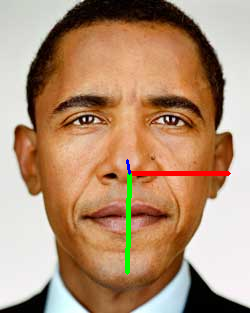

In [ ]:
img = draw_picture('blog_obama_martin_schoeller.jpg')
cv2_imshow(img)

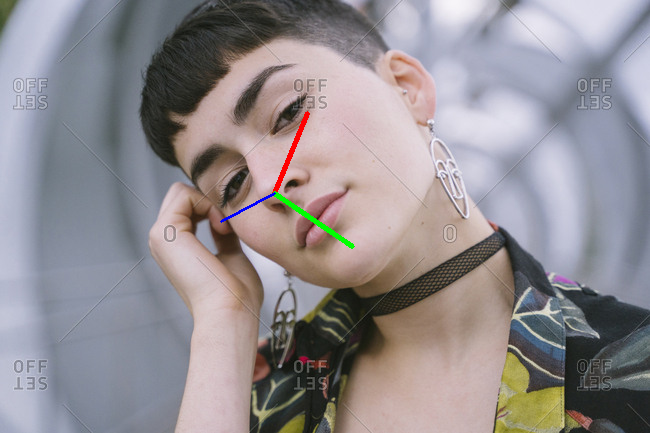

In [ ]:
img = draw_picture('tilte.jpg')
cv2_imshow(img)

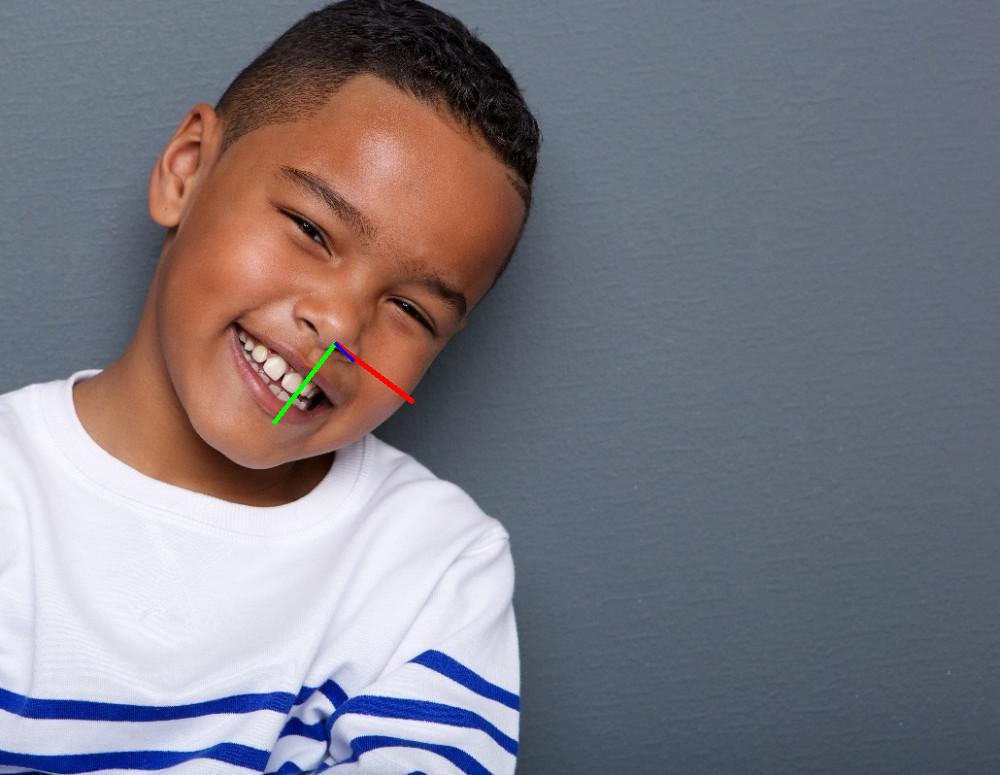

In [ ]:
img = draw_picture('test_me1.jpg')
cv2_imshow(img)

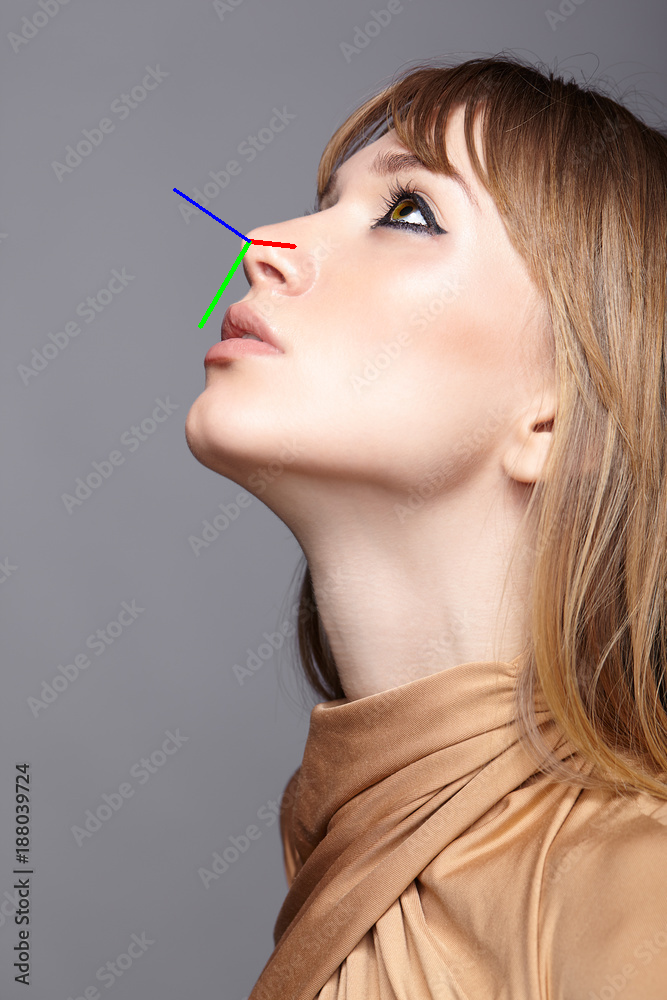

In [ ]:
cv2_imshow(draw_picture('up.jpg'))

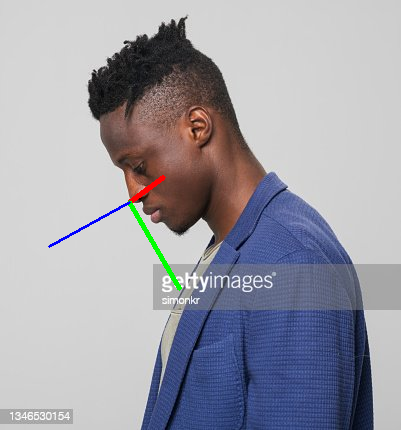

In [ ]:
cv2_imshow(draw_picture('down.jpg'))

## Functions to generate a video output

In [ ]:
# choosing random image
def get_feat_image(image):
  features_X = []
  features_Y = []
  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                features_X.append(x)
                features_Y.append(y)
  return np.array(features_X), np.array(features_Y)

def draw_picture_test(features_x, features_y, image):

  #prepare features for prediction
  features_x_relative = features_x - features_x[1]
  features_y_relative = features_y - features_y[1]
  vert_line = [10, 151, 9, 8, 168, 6, 197, 195, 5, 4, 1, 19, 24, 2, 164, 0, 11, 12, 13, 14, 15, 16, 17, 18, 200, 199, 175, 152]
  horz_line = [127, 34, 143, 35, 226, 130, 33, 190, 180, 193, 417, 413, 414, 398, 263, 359, 446, 265, 372, 264, 356]
  corners = [21, 251, 58, 288]
  relevant_pts = vert_line + horz_line + corners
  features_x_select = features_x_relative[relevant_pts]
  features_y_select = features_y_relative[relevant_pts]
  features_final = np.append(features_x_select, features_y_select).reshape(1, -1)
  features_final_full = np.append(features_x_relative, features_y_relative).reshape(1, -1)


  #predict axes
  roll = svr_winner_roll.predict(features_final_full)
  pitch = svr_winner_pitch.predict(features_final_full)
  yaw = svr_winner_yaw.predict(features_final_full)

  #draw axes on image
  shape = image.shape 
  nose_x = int(features_x[1] * shape[1])
  nose_y = int(features_y[1] * shape[0])
  img = draw_axis(image,pitch,yaw,roll, tdx=nose_x, tdy=nose_y)
  return img
  
def video_capture(path):
  cap = cv2.VideoCapture(path)

  width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

  cap.set(cv2.CAP_PROP_FPS, 30)
  cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

  mp_face_mesh = mediapipe.solutions.face_mesh
  
  size = (width, height)

  #video writer object that saves video in a file named output.mp4
  result = cv2.VideoWriter('output.mp4', 
                          cv2.VideoWriter_fourcc(*'MJPG'),
                          30, size)
  while cap.isOpened():
    with mp_face_mesh.FaceMesh(static_image_mode= False) as mesh_faces:
      success, frame = cap.read()
      if success:
        results = mesh_faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        # if a face is detected get its features, draw axes and write the new frames in the video file
        if results.multi_face_landmarks != None:
          features_x, features_y = get_feat_image(frame)
          image = draw_picture_test(features_x, features_y, frame)
          result.write(image)
        else:
        # if no face is detected write the original frame as it is
          result.write(frame)
      else:
        break

  cap.release()
  cv2.destroyAllWindows()
  result.release()

In [ ]:
video_capture('input.mp4')